## Multi-Task Learning

In [ ]:
pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.3 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=7ccce15ec23ac1aa8062ff1cf21923cee83e60012eca6e81cbac3d353d5e237c
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=1419b1c48878b3f0a1c5e1ce5081c324f0aa7086619ba742e0a598c0f8750e67
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [ ]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-wdosshbd
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-wdosshbd
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 8523324c116dcf7be6bddb73bf4eb1779ef6e611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.8 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

## Set Device

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Image

In [ ]:
img_path = 'sample_image.jpg'
mask_path = 'sample_masks.png'

(400, 600, 3)


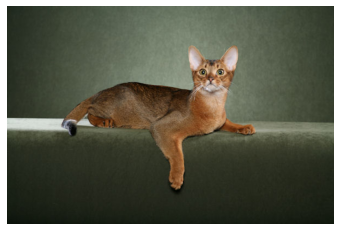

In [ ]:
img = Image.open(img_path).convert("RGB")
print(np.array(img).shape)
plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.show()

(400, 600)


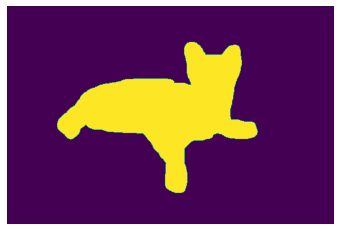

In [ ]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask
    
trimap = np.array(Image.open(mask_path))
masks = preprocess_mask(trimap)
print(masks.shape)
plt.imshow(masks)
plt.grid(False)
plt.axis('off')
plt.show()

## Load Datasets

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ADL Group Project')

In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

transform_y = transforms.Compose([transforms.Resize((512,512)), 
                                  transforms.ToTensor()])

In [ ]:
X = []
count = 0
image_names = []
for file_name in tqdm(os.listdir(sys.path[-1]+'/sample dataset/images')):
    image_names.append(file_name.split('.')[0])
    if file_name.split('.')[1] != 'jpg':
        continue
    image_path = sys.path[-1]+'/sample dataset/images/'+file_name
    img = Image.open(image_path).convert("RGB")
    x = transform(img)
    X.append(x.unsqueeze(dim=0))
    count += 1
    if count == 150:
        break
X = torch.cat(X, dim=0)
X.shape

 75%|███████▍  | 152/203 [00:05<00:01, 27.15it/s]


torch.Size([150, 3, 256, 256])

In [ ]:
Y = []
count = 0
for file_name in tqdm(image_names):
    masks_path = sys.path[-1]+'/sample dataset/trimaps/'+file_name+'.png'
    trimap = np.array(Image.open(masks_path))
    masks = preprocess_mask(trimap)
    y = transform_y(Image.fromarray((masks).astype(np.uint8)))
    y[y != 0] = 1
    Y.append(y.unsqueeze(dim=0))
    count += 1
    if count == 150:
        break
Y = torch.cat(Y, dim=0)
Y.shape

 97%|█████████▋| 149/153 [01:25<00:02,  1.74it/s]


torch.Size([150, 1, 512, 512])

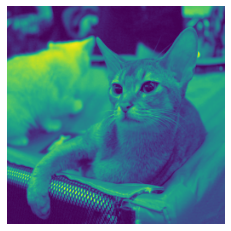

In [ ]:
plt.imshow(X[0].squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()

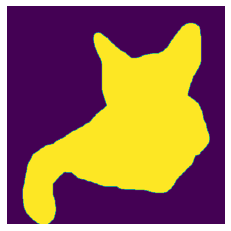

In [ ]:
plt.imshow(Y[0].squeeze())
plt.grid(False)
plt.axis('off')
plt.show()

In [ ]:
labels = np.array([1] * X.shape[0])

In [ ]:
dataset = TensorDataset([X.float(), Y.float(), torch.tensor(labels).float()])
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
print('Datasets ready!')

Datasets ready!


## DeepLab3v+

In [ ]:
aux_params = dict(
    pooling='avg',       # 'avg' or 'max'
    dropout=0.5,         # dropout ratio, default is None
    activation=None,     # 'sigmoid' or None
    classes=1,           # number of output labels: 0 (dog), 1 (cat)
    )
    
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    encoder_output_stride=16,        # 16 for semantic segmentation suggested in the paper for best trade-off between speech and accuracy
    decoder_atrous_rates=(6,12,18),  #dilation rates for ASPP, suggested in the paper
    decoder_channels=256,            # number of convolution filters in ASPP module (default=256)
    in_channels=3,                   # number of input channels (default=3, expects RGB images)
    upsampling=4,                    # final upsampling factor (default=4, to preserve input-output spatial shape identity) 
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=1,                       # number of segmentation classes
    aux_params=aux_params,           # parameters of the auxiliary output (defualt=None)
)
model.to(device)

## Dimension Check

In [ ]:
x = X[:2].to(device)
x.shape

torch.Size([2, 3, 256, 256])

In [ ]:
model.eval()
with torch.no_grad():
    outputs, clf_outputs = model(x)
outputs.shape

torch.Size([2, 1, 512, 512])

In [ ]:
clf_outputs

tensor([[ 0.0320],
        [-0.0481]], device='cuda:0')

In [ ]:
clf_outputs.squeeze()

tensor([ 0.0320, -0.0481], device='cuda:0')

## Training

In [ ]:
lr = 1e-4
num_epochs = 20

seg_w, clf_w = 1.0, 0.5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    train_loss_i = 0.0
    for images, masks, labels in tqdm(train_loader):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)

        outputs, clf_outputs = model(images)
        seg_loss = criterion(outputs.squeeze(), masks.squeeze())
        clf_loss = criterion(clf_outputs.squeeze(), labels.squeeze())
        loss = seg_w * seg_loss + clf_w * clf_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_i += loss.item()

    print('Training loss: {}'.format(train_loss_i/len(train_loader.dataset)))

# torch.save(model.state_dict(), 'trained_model.pth')

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Training loss: 0.029517672459284463


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Training loss: 0.02484756529331207


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Training loss: 0.019448552131652832


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Training loss: 0.016494687000910443


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Training loss: 0.01449663758277893


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Training loss: 0.013874666690826416


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Training loss: 0.012428324023882548


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.011701582372188568


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.011046633025010426


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.01150789310534795


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Training loss: 0.010573004285494486


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.009965741833051045


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Training loss: 0.009802299439907075


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Training loss: 0.009200355013211568


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Training loss: 0.008689435472091039


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.00865608662366867


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.0085648413002491


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Training loss: 0.007729599724213282


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Training loss: 0.007426021248102188


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

Training loss: 0.007762102335691452


In [ ]:
# torch.save(model.state_dict(), 'trained_model.pth')

## Inference

In [ ]:
x = X[5].unsqueeze(dim=0).to(device)
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
model.eval()
with torch.no_grad():
    output, clf_output = model(x)
output.shape

torch.Size([1, 1, 512, 512])

In [ ]:
output = output.detach().cpu().numpy().squeeze()
print(output.shape)

(512, 512)


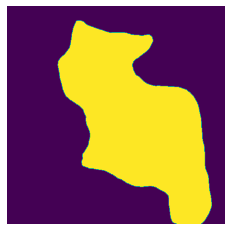

In [ ]:
output[output >= 0.5] = 1
output[output < 0.5] = 0
np.unique(output)

plt.imshow(output)
plt.grid(False)
plt.axis('off')
plt.show()

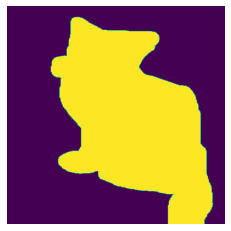

In [ ]:
plt.imshow(Y[5].squeeze())
plt.grid(False)
plt.axis('off')
plt.show()

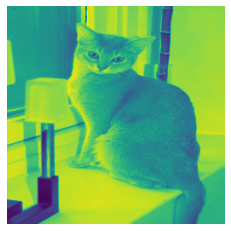

In [ ]:
plt.imshow(X[5].squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()

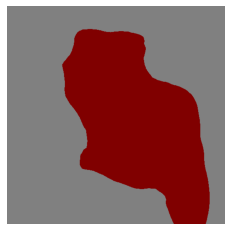

In [ ]:
colors = [(128, 128, 128), (128, 0, 0)]

segmentation = output
segmentation_colored = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

for class_index in range(len(colors)):
    segmentation_colored[segmentation==class_index, :] = colors[class_index]

pred_mask = Image.fromarray(segmentation_colored)
plt.imshow(pred_mask)
plt.grid(False)
plt.axis('off')
plt.show()